In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import linear_model
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from livelossplot.inputs.keras import PlotLossesCallback

In [2]:
font_size = 16
plt.rcParams.update({'font.size': font_size, 
                     'axes.edgecolor': 'white',
                     'axes.grid': True})

In [3]:
clean_data = pd.read_csv('clean_data.csv', index_col=0, header=[0, 1], date_format='%Y-%m-%d %H:%M:%S')
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47031 entries, 2022-01-17 17:10:00 to 2022-09-23 13:45:00
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   (Tank 1, O2 perc)                 46401 non-null  float64
 1   (Tank 1, pH regulator in flow)    47011 non-null  float64
 2   (Tank 1, Sludge recycle in flow)  47031 non-null  float64
 3   (Tank 1, Air in flow)             47031 non-null  float64
 4   (Tank 1, Content height)          42993 non-null  float64
 5   (Tank 1, pH)                      47011 non-null  float64
 6   (Tank 1, O2 dissolved)            46953 non-null  float64
 7   (Tank 1, Temperature)             46955 non-null  float64
 8   (Exit, Sludge concentration)      47021 non-null  float64
 9   (Exit, Conductivity)              47021 non-null  float64
 10  (Tank 2, O2 perc)                 46418 non-null  float64
 11  (Tank 2, pH regulator in flow)  

In [4]:
clean_data.head()

Location               Tank 1                                              \
Custom Name           O2 perc pH regulator in flow Sludge recycle in flow   
2022-01-17 17:10:00  18.29834             27.83947               99.93546   
2022-01-17 17:15:00  18.29748             27.67788               99.93343   
2022-01-17 17:20:00  18.29662             27.51629               99.93140   
2022-01-17 17:25:00  18.29576             27.35470               99.92937   
2022-01-17 17:30:00  18.29490             27.19311               99.92734   

Location                                                               \
Custom Name         Air in flow Content height        pH O2 dissolved   
2022-01-17 17:10:00    747.0399            NaN  7.298596     1.609646   
2022-01-17 17:15:00    744.1708            NaN  7.298001     1.607517   
2022-01-17 17:20:00    741.3018            NaN  7.297405     1.605388   
2022-01-17 17:25:00    738.4326            NaN  7.296809     1.603259   
2022-01-17 17:30:00    735.5635            NaN  7.296214     1.601130   

Location                                        Exit               ...  \
Custom Name         Temperature Sludge concentration Conductivity  ...   
2022-01-17 17:10:00    26.66654             1.502616     35.95628  ...   
2022-01-17 17:15:00    26.66875             1.504003     35.88463  ...   
2022-01-17 17:20:00    26.67095             1.505389     35.81298  ...   
2022-01-17 17:25:00    26.67315             1.506775     35.74133  ...   
2022-01-17 17:30:00    26.67536             1.508161     35.66968  ...   

Location                 Input A                         Input B            \
Custom Name         Conductivity       TOC        pH Temperature  Flowrate   
2022-01-17 17:10:00     51.19062  14.25161  6.559590    24.44635  29.16244   
2022-01-17 17:15:00     51.17931  14.18093  6.424222    24.59840  17.46023   
2022-01-17 17:20:00     51.16800  14.11025  6.634570    24.59937  45.92802   
2022-01-17 17:25:00     51.15670  14.03957  6.639138    24.30975  30.36573   
2022-01-17 17:30:00     51.14539  13.96888  6.662630    24.10653  26.96781   

Location                                                             Exit  
Custom Name         Amount of sludge Conductivity TOC        pH    Target  
2022-01-17 17:10:00         144.6119     2.364562 NaN  6.930508  67.15141  
2022-01-17 17:15:00         144.4974     2.368205 NaN  6.931771  67.14989  
2022-01-17 17:20:00         144.3829     2.371849 NaN  6.933034  67.14836  
2022-01-17 17:25:00         144.2685     2.375492 NaN  6.934297  67.14684  
2022-01-17 17:30:00         144.1540     2.379136 NaN  6.935560  67.14531  

[5 rows x 31 columns]

### Removing irrelevant columns

We already removed the columns that are not relevant for our analysis. However, we still have some columns that won't be useful for the prediction of the output contamination.

In [5]:
clean_data = clean_data.drop(['O2 perc'], axis=1, level=1)

In [6]:
clean_data.head()

Location                          Tank 1                                     \
Custom Name         pH regulator in flow Sludge recycle in flow Air in flow   
2022-01-17 17:10:00             27.83947               99.93546    747.0399   
2022-01-17 17:15:00             27.67788               99.93343    744.1708   
2022-01-17 17:20:00             27.51629               99.93140    741.3018   
2022-01-17 17:25:00             27.35470               99.92937    738.4326   
2022-01-17 17:30:00             27.19311               99.92734    735.5635   

Location                                                               \
Custom Name         Content height        pH O2 dissolved Temperature   
2022-01-17 17:10:00            NaN  7.298596     1.609646    26.66654   
2022-01-17 17:15:00            NaN  7.298001     1.607517    26.66875   
2022-01-17 17:20:00            NaN  7.297405     1.605388    26.67095   
2022-01-17 17:25:00            NaN  7.296809     1.603259    26.67315   
2022-01-17 17:30:00            NaN  7.296214     1.601130    26.67536   

Location                            Exit                            Tank 2  \
Custom Name         Sludge concentration Conductivity pH regulator in flow   
2022-01-17 17:10:00             1.502616     35.95628             22.44509   
2022-01-17 17:15:00             1.504003     35.88463             22.34081   
2022-01-17 17:20:00             1.505389     35.81298             22.23652   
2022-01-17 17:25:00             1.506775     35.74133             22.13224   
2022-01-17 17:30:00             1.508161     35.66968             22.02796   

Location             ...      Input A                         Input B  \
Custom Name          ... Conductivity       TOC        pH Temperature   
2022-01-17 17:10:00  ...     51.19062  14.25161  6.559590    24.44635   
2022-01-17 17:15:00  ...     51.17931  14.18093  6.424222    24.59840   
2022-01-17 17:20:00  ...     51.16800  14.11025  6.634570    24.59937   
2022-01-17 17:25:00  ...     51.15670  14.03957  6.639138    24.30975   
2022-01-17 17:30:00  ...     51.14539  13.96888  6.662630    24.10653   

Location                                                                   \
Custom Name          Flowrate Amount of sludge Conductivity TOC        pH   
2022-01-17 17:10:00  29.16244         144.6119     2.364562 NaN  6.930508   
2022-01-17 17:15:00  17.46023         144.4974     2.368205 NaN  6.931771   
2022-01-17 17:20:00  45.92802         144.3829     2.371849 NaN  6.933034   
2022-01-17 17:25:00  30.36573         144.2685     2.375492 NaN  6.934297   
2022-01-17 17:30:00  26.96781         144.1540     2.379136 NaN  6.935560   

Location                 Exit  
Custom Name            Target  
2022-01-17 17:10:00  67.15141  
2022-01-17 17:15:00  67.14989  
2022-01-17 17:20:00  67.14836  
2022-01-17 17:25:00  67.14684  
2022-01-17 17:30:00  67.14531  

[5 rows x 29 columns]

### Splitting dataset into train and validation sets

We will use the first 70% of the data for training and the last 30% for validation.
By doing this all the way in the beginning, we avoid any data leakage from the validation set into the training set.
Since we are dealing with time series data, we will not use a random split, but rather a split based on the index.

In [7]:
train_size = int(len(clean_data) * 0.7)
train = clean_data.iloc[:train_size, :].copy()
validation = clean_data.iloc[train_size:, :].copy()

### Filling missing values

Before we can do any feature engineering, we need to fill the missing values.


##### Filling missing values in Tank 1 and 2
In the analysis we concluded that Tank 1 and 2 are connected. Using this information to our advantage, we can fill the missing value of one tank with the valid value of the other tank and vice versa.

In [8]:
tank1_train = train.loc[:, ('Tank 1', slice(None))].droplevel(0, axis=1)
tank1_validation = validation.loc[:, ('Tank 1', slice(None))].droplevel(0, axis=1)

tank2_train = train.loc[:, ('Tank 2', slice(None))].droplevel(0, axis=1)
tank2_validation = validation.loc[:, ('Tank 2', slice(None))].droplevel(0, axis=1)

tank1_train = tank1_train.fillna(tank2_train)
tank2_train = tank2_train.fillna(tank1_train)

tank1_validation = tank1_validation.fillna(tank2_validation)
tank2_validation = tank2_validation.fillna(tank1_validation)

In [9]:
pd.DataFrame({'Tank 1 Training # NaN': tank1_train.isna().sum(),
              'Tank 1 Validation # NaN': tank1_validation.isna().sum(),
              'Tank 2 Training # NaN': tank2_train.isna().sum(),
              'Tank 2 Validation # NaN': tank2_validation.isna().sum()})

,Tank 1 Training # NaN,Tank 1 Validation # NaN,Tank 2 Training # NaN,Tank 2 Validation # NaN
Custom Name,,,,
pH regulator in flow,0,0,0,0
Sludge recycle in flow,0,0,0,0
Air in flow,0,0,0,0
Content height,4038,0,4038,0
pH,0,0,0,0
O2 dissolved,0,0,0,0
Temperature,0,0,0,0


Unfortunately, we still have some missing values in the training set for Content Height. We saw that the most missing values in Content Height are in the beginning of the dataset. We will fill these missing values with the average of the training set. 
It is important to only take the average of the training set, because we don't want to use any information from the validation set and give the model information it shouldn't know about.

In [10]:
tank1_content_height_mean = tank1_train['Content height'].mean()
tank2_content_height_mean = tank2_train['Content height'].mean()

tank1_train['Content height'] = tank1_train['Content height'].fillna(tank1_content_height_mean)
tank2_train['Content height'] = tank2_train['Content height'].fillna(tank2_content_height_mean)

# Although there are no missing values anymore in the validation set, we will still fill the missing values with the average of the training set (for completion’s sake).
tank1_validation['Content height'] = tank1_validation['Content height'].fillna(tank1_content_height_mean)
tank2_validation['Content height'] = tank2_validation['Content height'].fillna(tank2_content_height_mean)

In [11]:
pd.DataFrame({'Tank 1 Training # NaN': tank1_train.isna().sum(),
              'Tank 1 Validation # NaN': tank1_validation.isna().sum(),
              'Tank 2 Training # NaN': tank2_train.isna().sum(),
              'Tank 2 Validation # NaN': tank2_validation.isna().sum()})


,Tank 1 Training # NaN,Tank 1 Validation # NaN,Tank 2 Training # NaN,Tank 2 Validation # NaN
Custom Name,,,,
pH regulator in flow,0,0,0,0
Sludge recycle in flow,0,0,0,0
Air in flow,0,0,0,0
Content height,0,0,0,0
pH,0,0,0,0
O2 dissolved,0,0,0,0
Temperature,0,0,0,0


We confirmed that there are no missing values anymore in the Tank 1 and 2 training and validation set.
Now we need to feed the data back into the original datasets.

In [12]:
train.loc[:, ('Tank 1', tank1_train.columns)] = tank1_train.values
train.loc[:, ('Tank 2', tank2_train.columns)] = tank2_train.values

validation.loc[:, ('Tank 1', tank1_validation.columns)] = tank1_validation.values
validation.loc[:, ('Tank 2', tank2_validation.columns)] = tank2_validation.values

In [13]:
pd.DataFrame({'Train # NaN': train.isna().sum(),
              'Validation # NaN': validation.isna().sum()})

Train # NaN  Validation # NaN
Location Custom Name                                          
Tank 1   pH regulator in flow              0                 0
         Sludge recycle in flow            0                 0
         Air in flow                       0                 0
         Content height                    0                 0
         pH                                0                 0
         O2 dissolved                      0                 0
         Temperature                       0                 0
Exit     Sludge concentration              9                 1
         Conductivity                     10                 0
Tank 2   pH regulator in flow              0                 0
         Sludge recycle in flow            0                 0
         Air in flow                       0                 0
         Content height                    0                 0
         pH                                0                 0
         O2 dissolved                      0                 0
         Temperature                       0                 0
Input A  Temperature                      23                 1
         Flowrate                      15754                 0
         Amount of sludge                  0                 0
         Conductivity                   3461                 0
         TOC                            2208                 0
         pH                             3434                 1
Input B  Temperature                    3131                 0
         Flowrate                       3131                 0
         Amount of sludge                  0                 0
         Conductivity                   3438                 0
         TOC                           14470                 0
         pH                             3123                 1
Exit     Target                            0                 0

##### Filling missing values in other variables

We see that the training set still has a lot of missing values (the validation set only 1 here and there). We will fill these missing values with the average of the training set.

In [14]:
mean_values = train.mean()
train = train.fillna(mean_values)
validation = validation.fillna(mean_values)

### Normalizing data

Because the variables have different scales, we will normalize the data. We normalize them by setting their mean to 0 and their standard deviation to 1.
Again we can only use the training set to calculate the mean and standard deviation, because we don't want to leak any information from the validation set into the training set.

In [15]:
mean_values = train.mean()
std_values = train.std()

target_mean = train.loc[:, ('Exit', 'Target')].mean()
target_std = train.loc[:, ('Exit', 'Target')].std()

train = (train - mean_values) / std_values
validation = (validation - mean_values) / std_values

### Feature engineering
Our datasets have a lot of variables. We will use PCA to reduce the number of variables, specifically Tank 1 and 2.

In [16]:
selection = train.loc[:, (['Tank 1', 'Tank 2'], slice(None))].copy()

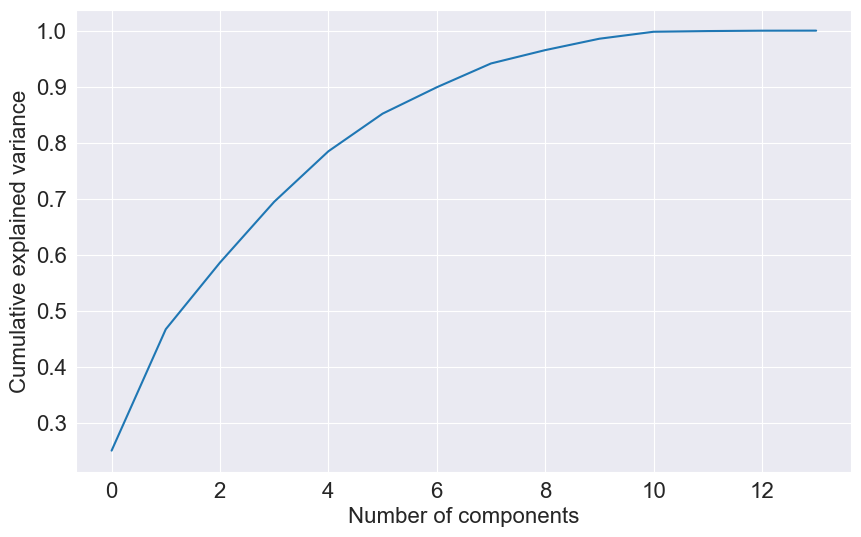

In [17]:
pca = PCA()
pca.fit(selection)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Explained variance ratio')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


We choose 10 components, because this is the lowest amount of components without losing information.

In [18]:
n_components = 10

pca = PCA(n_components=n_components)
pca.fit(selection)

PCA(n_components=10)

In [19]:
train_tank_pca = pd.DataFrame(pca.transform(train[selection.columns]), 
                              index=train.index, 
                              columns=[f'Tank PCA {i}' for i in range(n_components)])
validation_tank_pca = pd.DataFrame(pca.transform(validation[selection.columns]), 
                                   index=validation.index, 
                                   columns=[f'Tank PCA {i}' for i in range(n_components)])

In [20]:
train_tank_pca.head()

,Tank PCA 0,Tank PCA 1,Tank PCA 2,Tank PCA 3,Tank PCA 4,Tank PCA 5,Tank PCA 6,Tank PCA 7,Tank PCA 8,Tank PCA 9
2022-01-17 17:10:00,0.380121,-0.064532,0.932902,-1.099377,0.122032,0.365548,0.121682,0.957991,0.063658,-0.043772
2022-01-17 17:15:00,0.388489,-0.060549,0.917750,-1.094271,0.112733,0.356519,0.127101,0.941214,0.066269,-0.049694
2022-01-17 17:20:00,0.396858,-0.056567,0.902589,-1.089145,0.103426,0.347490,0.132515,0.924410,0.068881,-0.055613
2022-01-17 17:25:00,0.405228,-0.052585,0.887430,-1.084018,0.094120,0.338461,0.137929,0.907607,0.071491,-0.061532
2022-01-17 17:30:00,0.416037,-0.047764,0.871384,-1.078787,0.084830,0.329042,0.144585,0.891275,0.073809,-0.065392


This now reduced the number of variables related to Tank 1 and 2 from 14 each to only 5 each.
We now merge this back into the original datasets and instead remove the original Tank 1 and 2 columns.

In [21]:
train_tank_pca.columns = pd.MultiIndex.from_product([['Tanks', ], train_tank_pca.columns])
validation_tank_pca.columns = pd.MultiIndex.from_product([['Tanks', ], validation_tank_pca.columns])

In [22]:
train_no_tanks_mask = ~(train.columns.get_level_values(0).isin(['Tank 1', 'Tank 2']))
validation_no_tanks_mask = ~(validation.columns.get_level_values(0).isin(['Tank 1', 'Tank 2']))

train_features = pd.concat([train_tank_pca, train[train.columns[train_no_tanks_mask]]], axis=1)
validation_features = pd.concat([validation_tank_pca, validation[validation.columns[validation_no_tanks_mask]]], axis=1)

### Shifting target to predict into the future

In [23]:
prediction_horizon = 7 # hours (good correlation to O2 Dissolved at 7 hours as seen during analysis)

In [24]:
train_shift_index = train_features.index - pd.Timedelta(hours=prediction_horizon)
validation_shift_index = validation_features.index - pd.Timedelta(hours=prediction_horizon)

train_shift_target = pd.Series(data=train_features.loc[:, ('Exit', 'Target')].values, 
                               index=train_shift_index, 
                               name='Target')
validation_shift_target = pd.Series(data=validation_features.loc[:, ('Exit', 'Target')].values, 
                                    index=validation_shift_index, 
                                    name='Target')

common_train_index = train_shift_index.intersection(train_features.index)
common_validation_index = validation_shift_index.intersection(validation_features.index)

In [25]:
train_target = train_shift_target.loc[common_train_index]
validation_target = validation_shift_target.loc[common_validation_index]

train_target_unnormalized = (train_target * target_std) + target_mean
validation_target_unnormalized = (validation_target * target_std) + target_mean

train_features = train_features.loc[common_train_index]
validation_features = validation_features.loc[common_validation_index]

### Functions for model evaluation

In [26]:
def show_model_results(model_train_predictions, model_validation_predictions, model_name, y_true_train=None, y_true_val=None):
    if y_true_train is None:
        y_true_train = train_target_unnormalized
    if y_true_val is None:
        y_true_val = validation_target_unnormalized
    
    results = pd.DataFrame(index=[model_name, ],
                            columns=['Train MAE', 'Train MSE', 'Validation MAE', 'Validation MSE'])
    results['Train MAE'] = np.mean(np.abs(y_true_train - model_train_predictions))
    results['Train MSE'] = np.mean(np.square(y_true_train - model_train_predictions))
    results['Validation MAE'] = np.mean(np.abs(y_true_val - model_validation_predictions))
    results['Validation MSE'] = np.mean(np.square(y_true_val - model_validation_predictions))
    display(results)
    
    train_size = y_true_train.shape[0]
    validation_size = y_true_val.shape[0]
    
    fig, ax = plt.subplots(figsize=(17, 5))
    ax.plot(range(train_size), model_train_predictions, alpha=.75, color='C1', label='Training Predictions')
    ax.plot(range(train_size), y_true_train, alpha=.75, color='C0', linestyle='--', label='Training True')
    
    ax.plot(range(train_size, train_size + validation_size), model_validation_predictions, alpha=.75, color='C3', label='Validation Predictions')
    ax.plot(range(train_size, train_size + validation_size), y_true_val, alpha=.75, color='C2', linestyle='--', label='Validation True')
    ax.legend()
    
    ax.set_title('Prediction vs True = Training and Validation')

    return fig, ax, results

In [27]:
def analyze_residuals(model_train_predictions, model_validation_predictions, y_true_train=None, y_true_val=None):
    if y_true_train is None:
        y_true_train = train_target_unnormalized
    if y_true_val is None:
        y_true_val = validation_target_unnormalized
    
    fig, ax = plt.subplots(2, 2, figsize=(17, 7), gridspec_kw={'width_ratios': [2, 1]})
    
    train_residuals = y_true_train - model_train_predictions
    validation_residuals = y_true_val - model_validation_predictions
    
    relative_train_residuals = train_residuals / y_true_train
    relative_validation_residuals = validation_residuals / y_true_val
    
    train_size = y_true_train.shape[0]
    validation_size = y_true_val.shape[0]
    
    ax[0, 0].plot(range(train_size), train_residuals, color='C0', label='Training Error')
    ax[0, 0].plot(range(train_size, train_size + validation_size), validation_residuals, color='C1', label='Validation Error')
    ax[0, 0].legend()
    ax[0, 0].set_title('Training and Validation Error')
    
    ax[1, 0].plot(range(train_size), relative_train_residuals, color='C0', label='Relative Training Error')
    ax[1, 0].plot(range(train_size, train_size + validation_size), relative_validation_residuals, color='C1', label='Relative Validation Error')
    ax[1, 0].legend()
    ax[1, 0].set_title('Relative Training and Validation Error')
    
    ax[0, 1].hist(train_residuals, bins=100, color='C0', label='Training Error')
    ax[0, 1].axvline(train_residuals.mean(), color='C1', linestyle='--', label='Average')
    ax[0, 1].legend()
    ax[0, 1].set_title(f'Training {train_residuals.mean():.2f} ± {train_residuals.std():.2f}')
    
    ax[1, 1].hist(validation_residuals, bins=100, color='C0', label='Validation Error')
    ax[1, 1].axvline(validation_residuals.mean(), color='C1', linestyle='--', label='Average')
    ax[1, 1].legend()
    ax[1, 1].set_title(f'Validation {validation_residuals.mean():.2f} ± {validation_residuals.std():.2f}')
    
    fig.tight_layout()
    return fig, ax

In [28]:
def unnormalize_target(normalized_target):
    return (normalized_target * target_std) + target_mean

In [29]:
# to keep track of the results
model_results = []

### Baseline model

For the baseline model we will simply predict that the future value will be the same as the current value.

In [30]:
train_baseline_predictions =train_features.loc[:, ('Exit', 'Target')] * target_std + target_mean
validation_baseline_predictions = validation_features.loc[:, ('Exit', 'Target')] * target_std + target_mean

,Train MAE,Train MSE,Validation MAE,Validation MSE
Baseline Model,14.652599,990.940456,4.680117,212.830491


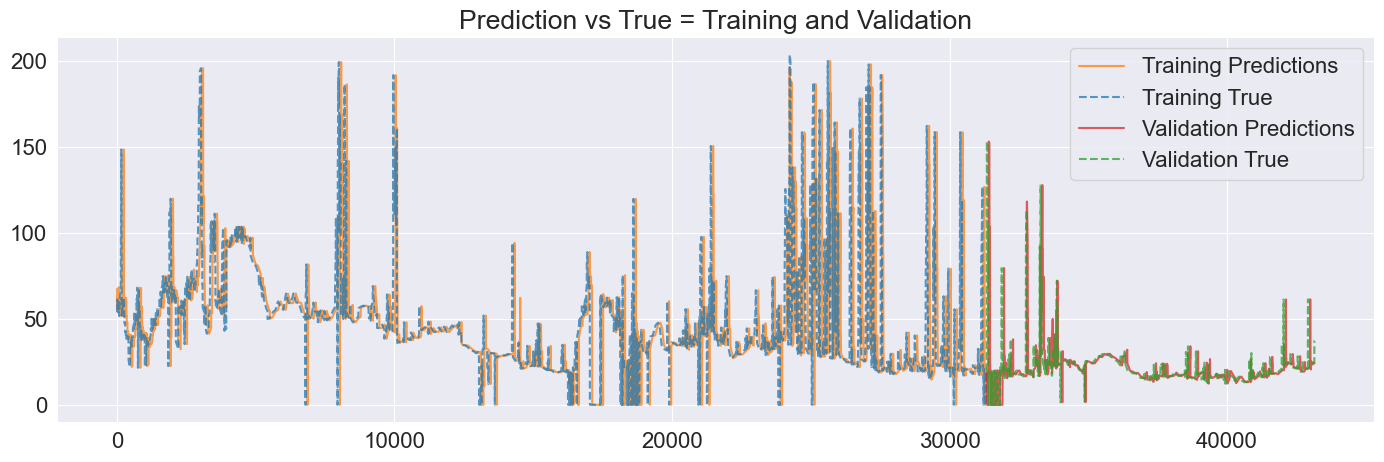

In [31]:
fig, ax, results = show_model_results(train_baseline_predictions, validation_baseline_predictions, 'Baseline Model')
model_results.append(results)

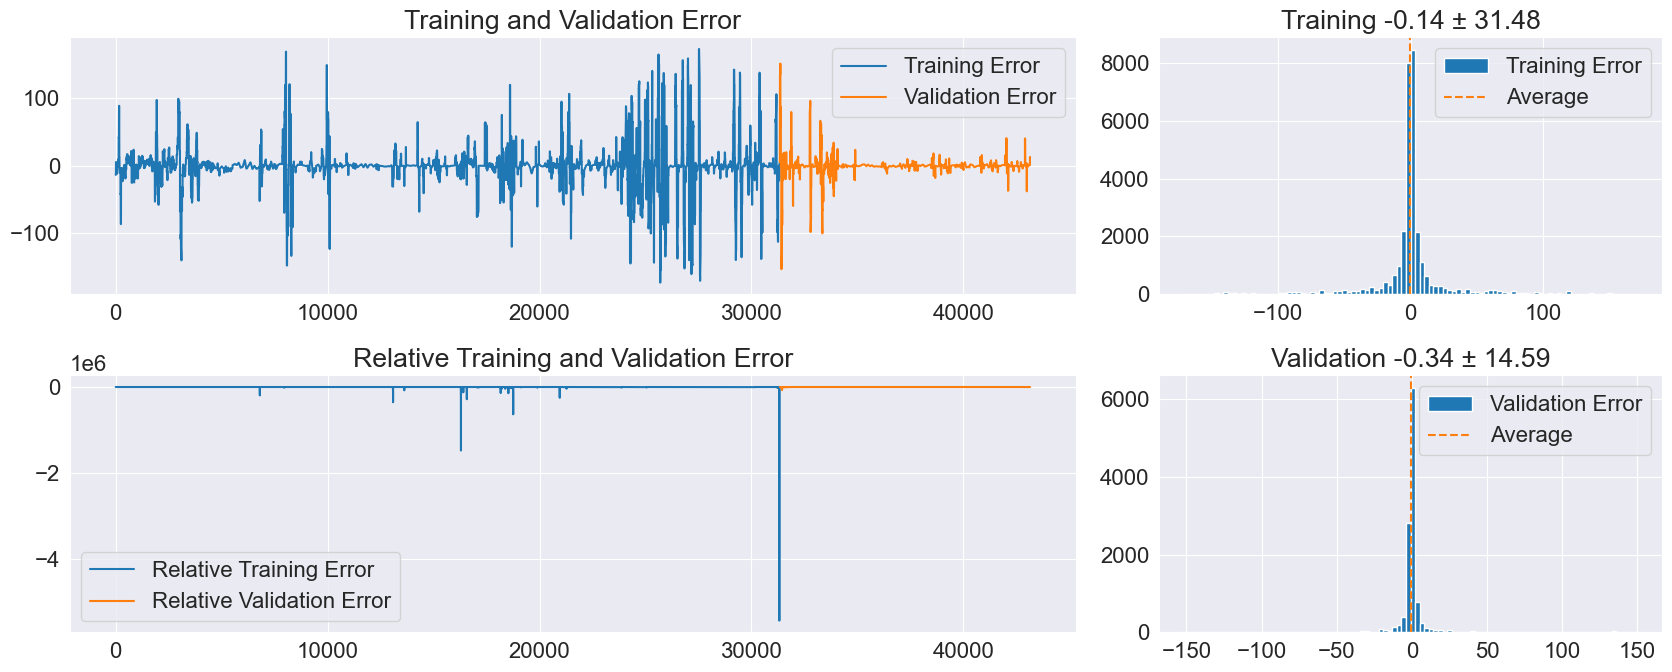

In [32]:
fig, ax = analyze_residuals(train_baseline_predictions, validation_baseline_predictions)

### Linear regression model

We will use a linear regression model as our first model.

In [33]:
linear_regression_model = linear_model.LinearRegression()
linear_regression_model.fit(train_features, train_target)

LinearRegression()

In [34]:
train_predictions = unnormalize_target(linear_regression_model.predict(train_features))
validation_predictions = unnormalize_target(linear_regression_model.predict(validation_features))

,Train MAE,Train MSE,Validation MAE,Validation MSE
Linear Regression Model,15.432197,645.554839,38.469567,1773.93565


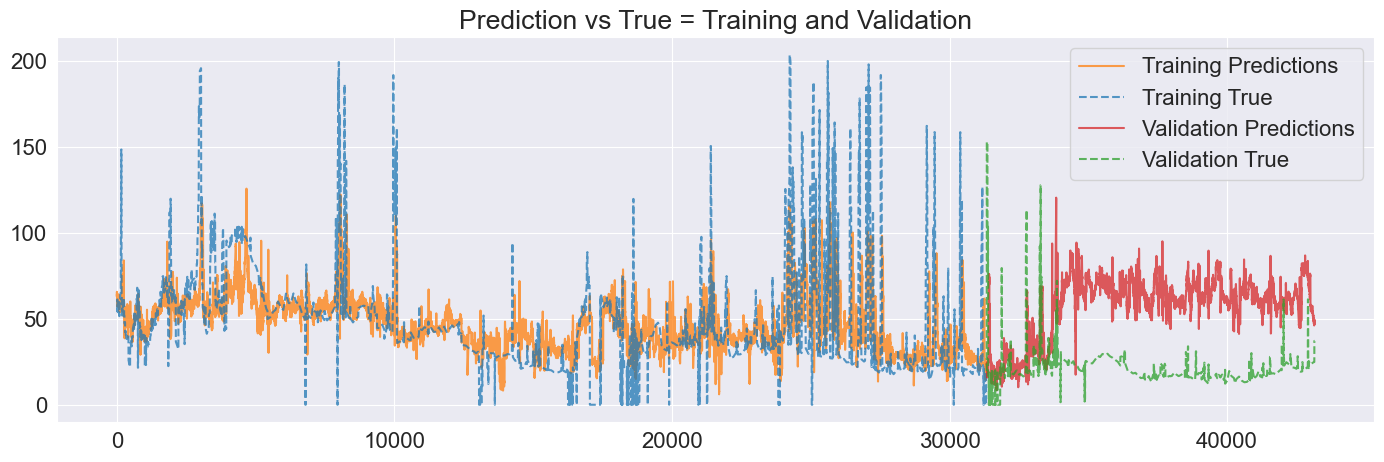

In [35]:
fig, ax, results = show_model_results(train_predictions, validation_predictions, 'Linear Regression Model')
model_results.append(results)

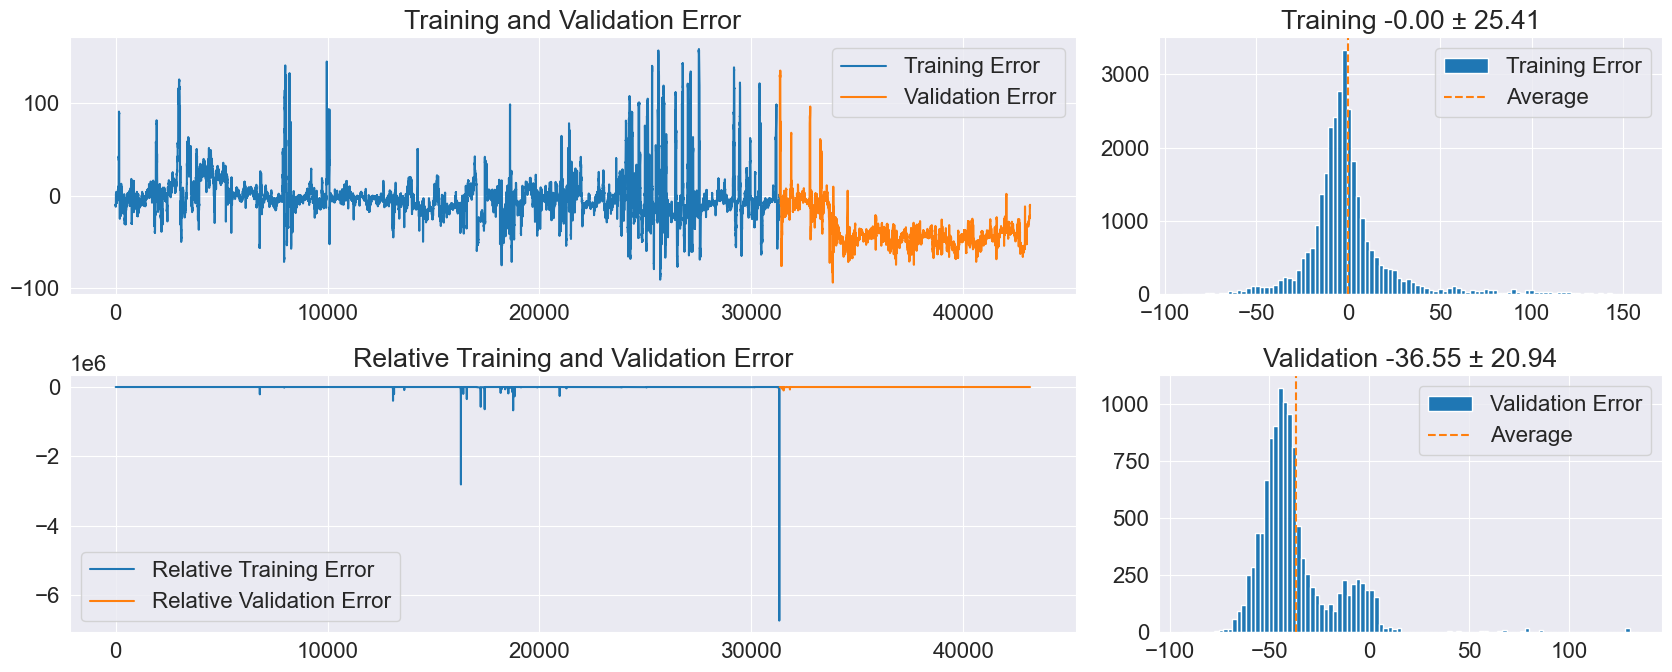

In [36]:
fig, ax = analyze_residuals(train_predictions, validation_predictions)

### Gradient boosting model

We will use a gradient boosting model as our second model. We will use grid search to find the best parameters for the model.

In [37]:
params = {
    'max_depth': [3, 10],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 150],
}

xgbr = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgbr, param_grid=params, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(train_features, train_target)

xgb_regressor = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [38]:
train_predictions = unnormalize_target(xgb_regressor.predict(train_features))
validation_predictions = unnormalize_target(xgb_regressor.predict(validation_features))

,Train MAE,Train MSE,Validation MAE,Validation MSE
Gradient Boosting Model,16.932667,692.604269,30.69996,1047.920492


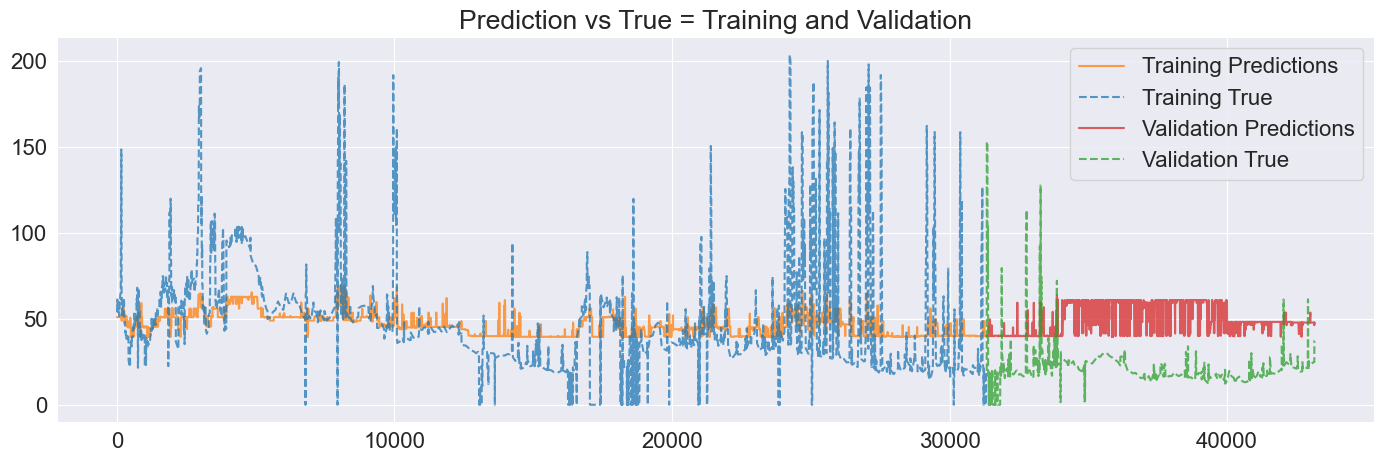

In [39]:
fig, ax, results = show_model_results(train_predictions, validation_predictions, 'Gradient Boosting Model')
model_results.append(results)

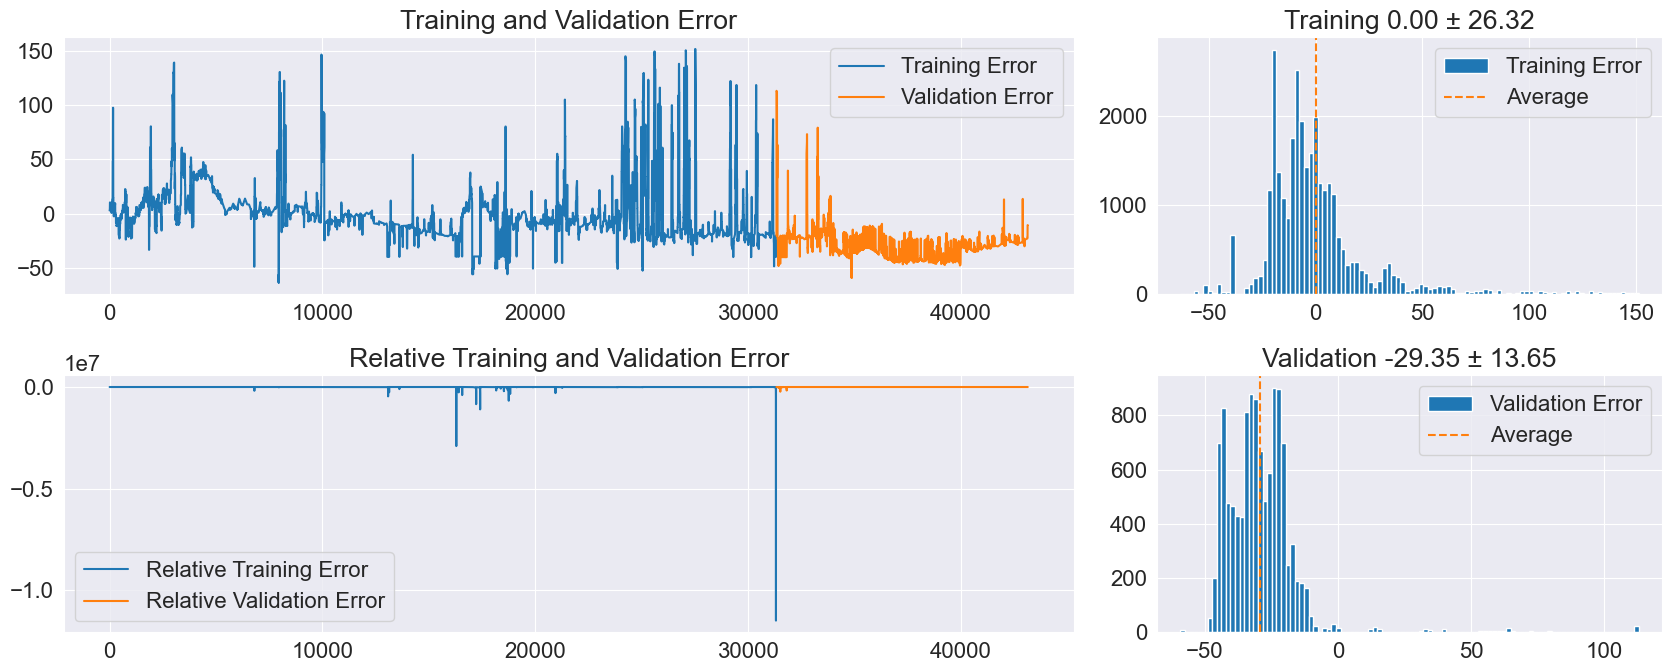

In [40]:
fig, ax = analyze_residuals(train_predictions, validation_predictions)

In [41]:
BATCH_SIZE = 128
EPOCHS = 50

In [42]:
plotlosses = PlotLossesCallback()

In [43]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=[train_features.shape[1]]),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [44]:
train_tf_x = tf.data.Dataset.from_tensor_slices(train_features)
train_tf_y = tf.data.Dataset.from_tensor_slices(train_target)
training_set = tf.data.Dataset.zip((train_tf_x, train_tf_y)).batch(BATCH_SIZE)

validation_tf_x = tf.data.Dataset.from_tensor_slices(validation_features)
validation_tf_y = tf.data.Dataset.from_tensor_slices(validation_target)
validation_set = tf.data.Dataset.zip((validation_tf_x, validation_tf_y)).batch(BATCH_SIZE)

In [45]:
simple_tf_model = build_model()

In [46]:
simple_tf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                416       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 593 (2.32 KB)
Trainable params: 593 (2.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


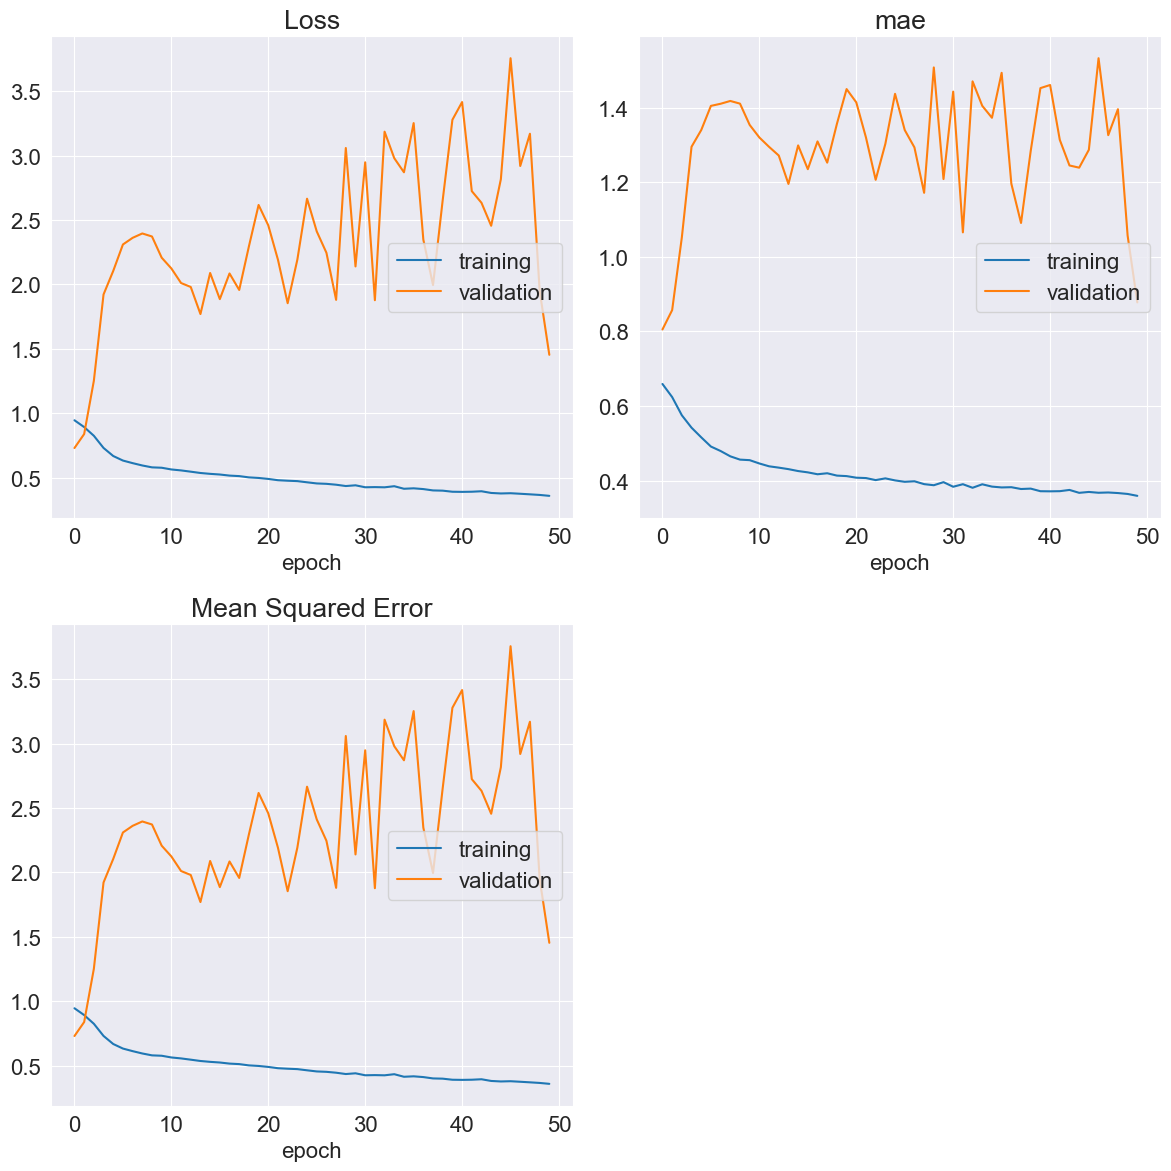

Loss
	training         	 (min:    0.359, max:    0.945, cur:    0.359)
	validation       	 (min:    0.730, max:    3.755, cur:    1.453)
mae
	training         	 (min:    0.359, max:    0.659, cur:    0.359)
	validation       	 (min:    0.805, max:    1.533, cur:    0.878)
Mean Squared Error
	training         	 (min:    0.359, max:    0.945, cur:    0.359)
	validation       	 (min:    0.730, max:    3.755, cur:    1.453)
245/245 [==============================] - 1s 2ms/step - loss: 0.3588 - mae: 0.3589 - mse: 0.3588 - val_loss: 1.4534 - val_mae: 0.8779 - val_mse: 1.4534


In [47]:
simple_tf_model.fit(training_set.shuffle(BATCH_SIZE), 
                    epochs=EPOCHS, 
                    validation_data=validation_set, 
                    callbacks=[plotlosses])

In [48]:
train_predictions = unnormalize_target(simple_tf_model.predict(train_features))[:, 0]
validation_predictions = unnormalize_target(simple_tf_model.predict(validation_features))[:, 0]

370/370 [==============================] - 0s 271us/step


,Train MAE,Train MSE,Validation MAE,Validation MSE
Feed Forward Neural Network Model,10.750235,334.298621,26.943641,1369.031602


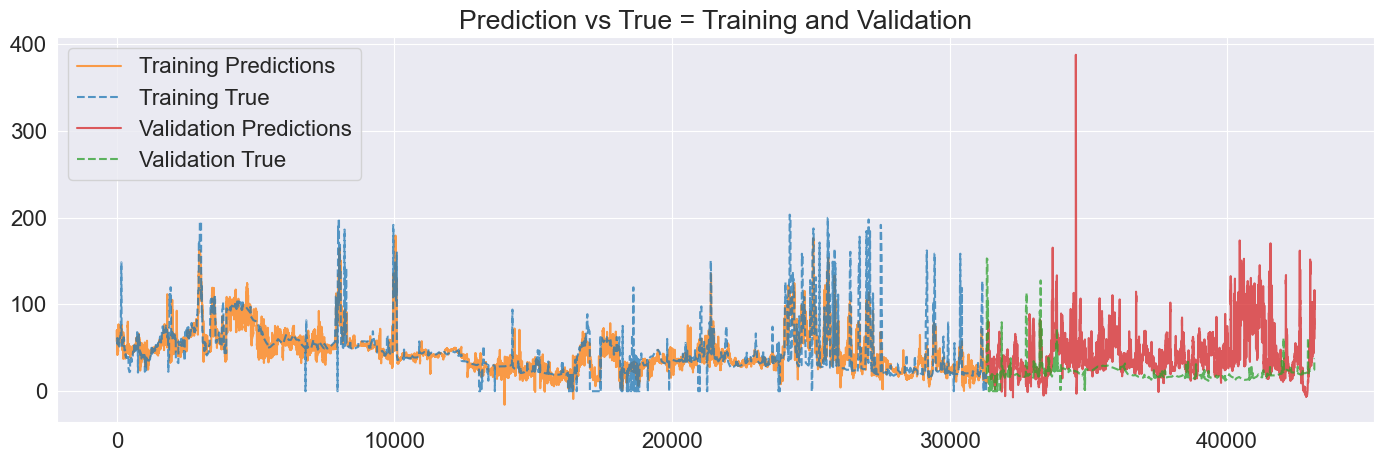

In [49]:
fig, ax, results = show_model_results(train_predictions, validation_predictions, 'Feed Forward Neural Network Model')
model_results.append(results)

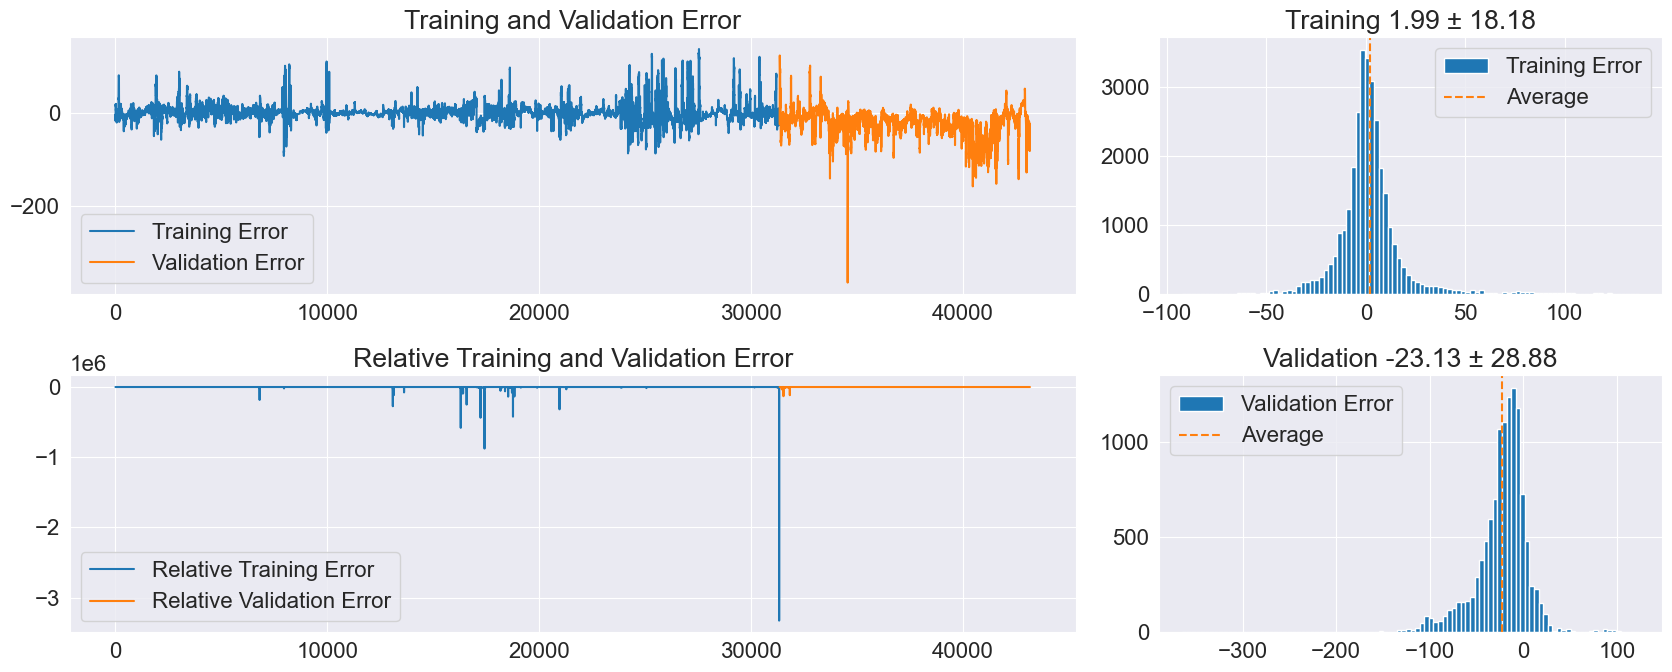

In [50]:
fig, ax = analyze_residuals(train_predictions, validation_predictions)

### LSTM Neural Network
We now try a Long-Short Term Memory (LSTM) Neural Network. This is a type of Recurrent Neural Network (RNN) that is good at predicting time series data, because it can remember information from previous time steps.

In [51]:
def build_lstm_model(time_input: int):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(8, input_shape=[time_input, train_features.shape[1]]),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

    model.compile(loss=tf.keras.losses.mean_squared_error,
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [52]:
time_window = 24
model = build_lstm_model(time_window)

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 1088      
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 4)                 36        
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1201 (4.69 KB)
Trainable params: 1201 (4.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
training_set = tf.keras.utils.timeseries_dataset_from_array(
    train_features.values,
    train_target.values[time_window-1:],
    time_window,
    batch_size=BATCH_SIZE,
    shuffle=True)

training_set_no_shuffle = tf.keras.utils.timeseries_dataset_from_array(
    train_features.values,
    train_target.values[time_window-1:],
    time_window,
    batch_size=BATCH_SIZE,
    shuffle=False)

validation_set = tf.keras.utils.timeseries_dataset_from_array(
    validation_features.values,
    validation_target.values[time_window-1:],
    time_window,
    batch_size=BATCH_SIZE,
    shuffle=False)

In [55]:
plotlosses = PlotLossesCallback()

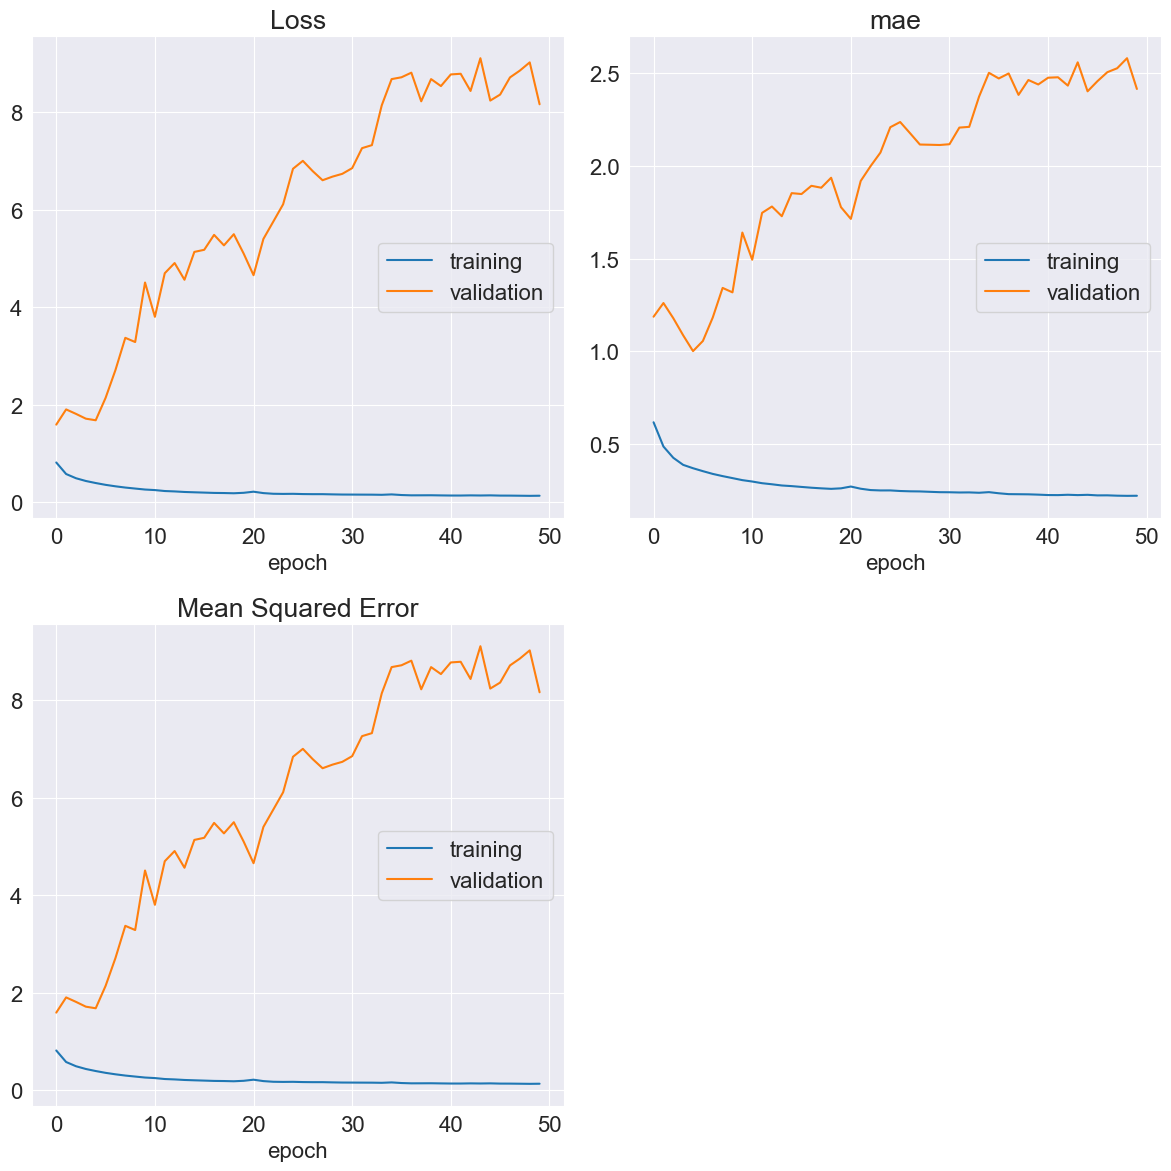

Loss
	training         	 (min:    0.126, max:    0.811, cur:    0.128)
	validation       	 (min:    1.589, max:    9.115, cur:    8.169)
mae
	training         	 (min:    0.221, max:    0.618, cur:    0.222)
	validation       	 (min:    1.001, max:    2.580, cur:    2.414)
Mean Squared Error
	training         	 (min:    0.126, max:    0.811, cur:    0.128)
	validation       	 (min:    1.589, max:    9.115, cur:    8.169)
245/245 [==============================] - 2s 6ms/step - loss: 0.1283 - mae: 0.2218 - mse: 0.1283 - val_loss: 8.1690 - val_mae: 2.4141 - val_mse: 8.1690


In [56]:
model.fit(training_set, 
          epochs=EPOCHS, 
          validation_data=validation_set, 
          callbacks=[plotlosses])

In [57]:
train_predictions = unnormalize_target(model.predict(training_set_no_shuffle))[:, 0]
validation_predictions = unnormalize_target(model.predict(validation_set))[:, 0]

93/93 [==============================] - 0s 3ms/step


In [58]:
y_train_lstm = train_target_unnormalized[time_window-1:(train_predictions.shape[0] + time_window-1)]
y_val_lstm = validation_target_unnormalized[time_window-1:(validation_predictions.shape[0] + time_window-1)]

,Train MAE,Train MSE,Validation MAE,Validation MSE
LSTM Neural Network Model,6.682548,114.757679,74.093756,7694.964232


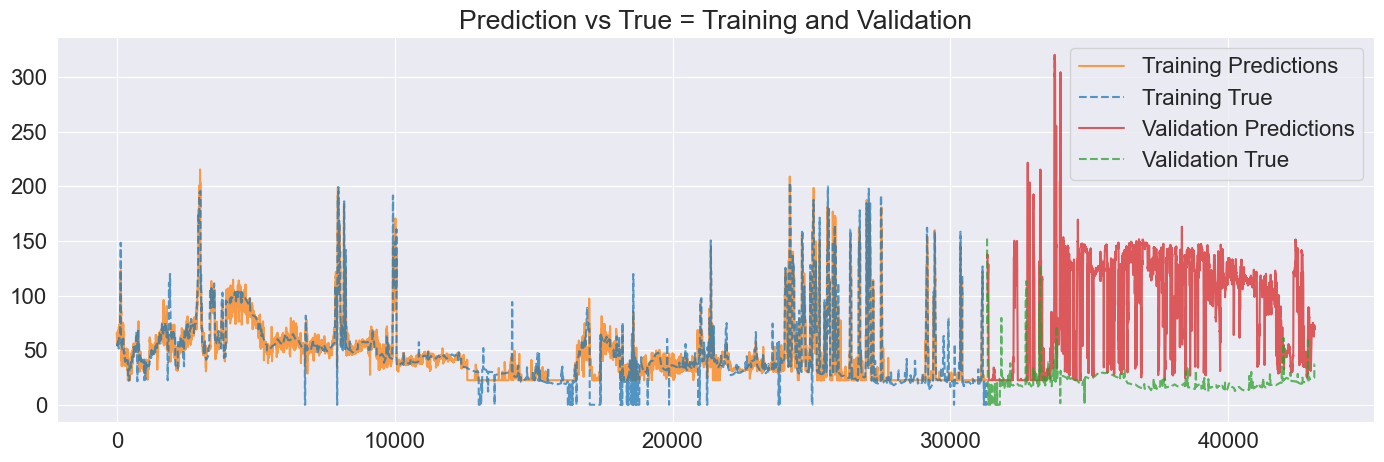

In [59]:
fig, ax, results = show_model_results(train_predictions, validation_predictions, 'LSTM Neural Network Model', y_train_lstm, y_val_lstm)
model_results.append(results)

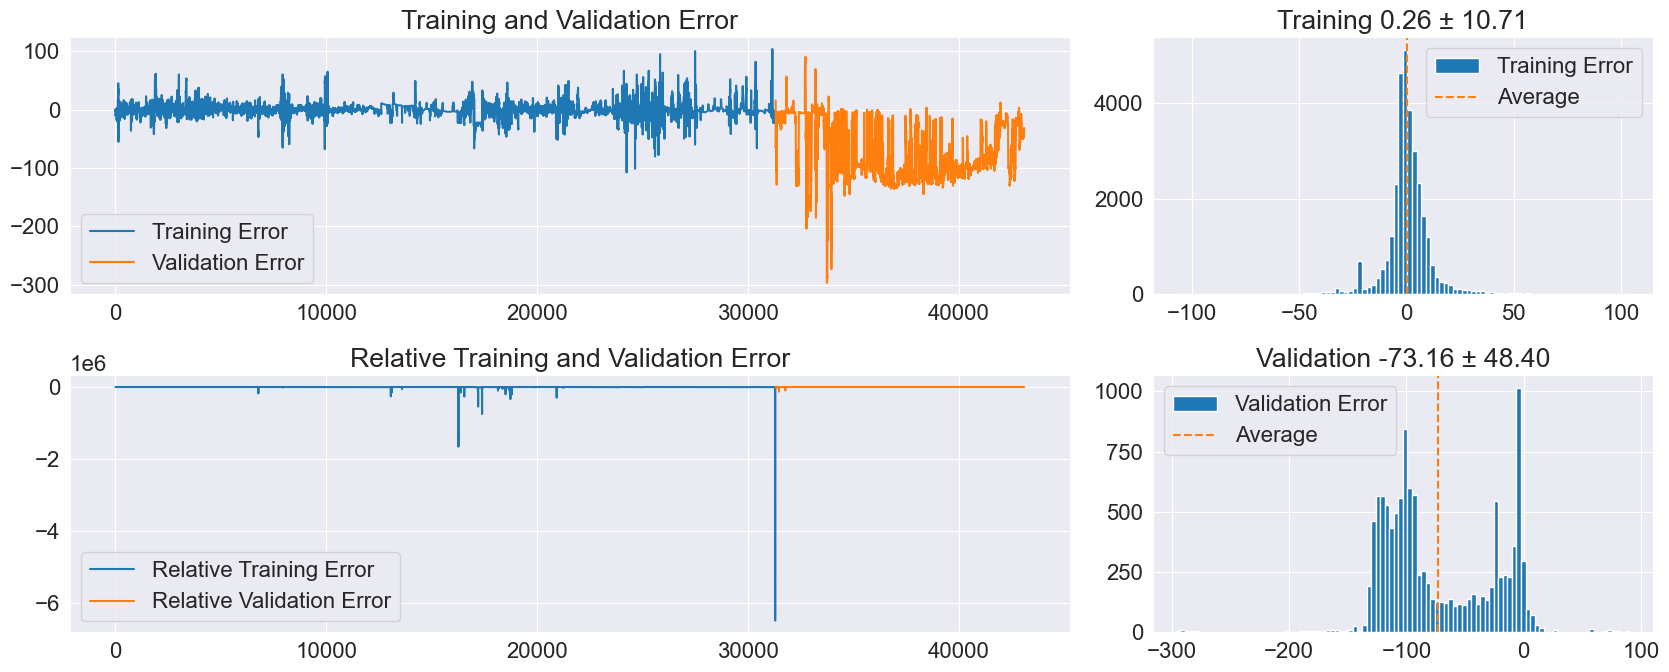

In [60]:
fig, ax = analyze_residuals(train_predictions, validation_predictions, y_train_lstm, y_val_lstm)

### Feed forward neural network with multiple time steps

We will now try a feed forward neural network with multiple time steps.

In [61]:
def build_multi_step_model(time_input: int):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(16, 3, activation='relu', input_shape=[time_input, train_features.shape[1]]),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Reshape((-1, )),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

    model.compile(loss=tf.keras.losses.mean_squared_error,
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [62]:
fw_multi_timestep_model = build_multi_step_model(time_window)

In [63]:
fw_multi_timestep_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 16)            1216      
                                                                 
 dense_7 (Dense)             (None, 22, 8)             136       
                                                                 
 dense_8 (Dense)             (None, 22, 4)             36        
                                                                 
 reshape (Reshape)           (None, 88)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 89        
                                                                 
Total params: 1477 (5.77 KB)
Trainable params: 1477 (5.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
plotlosses = PlotLossesCallback()

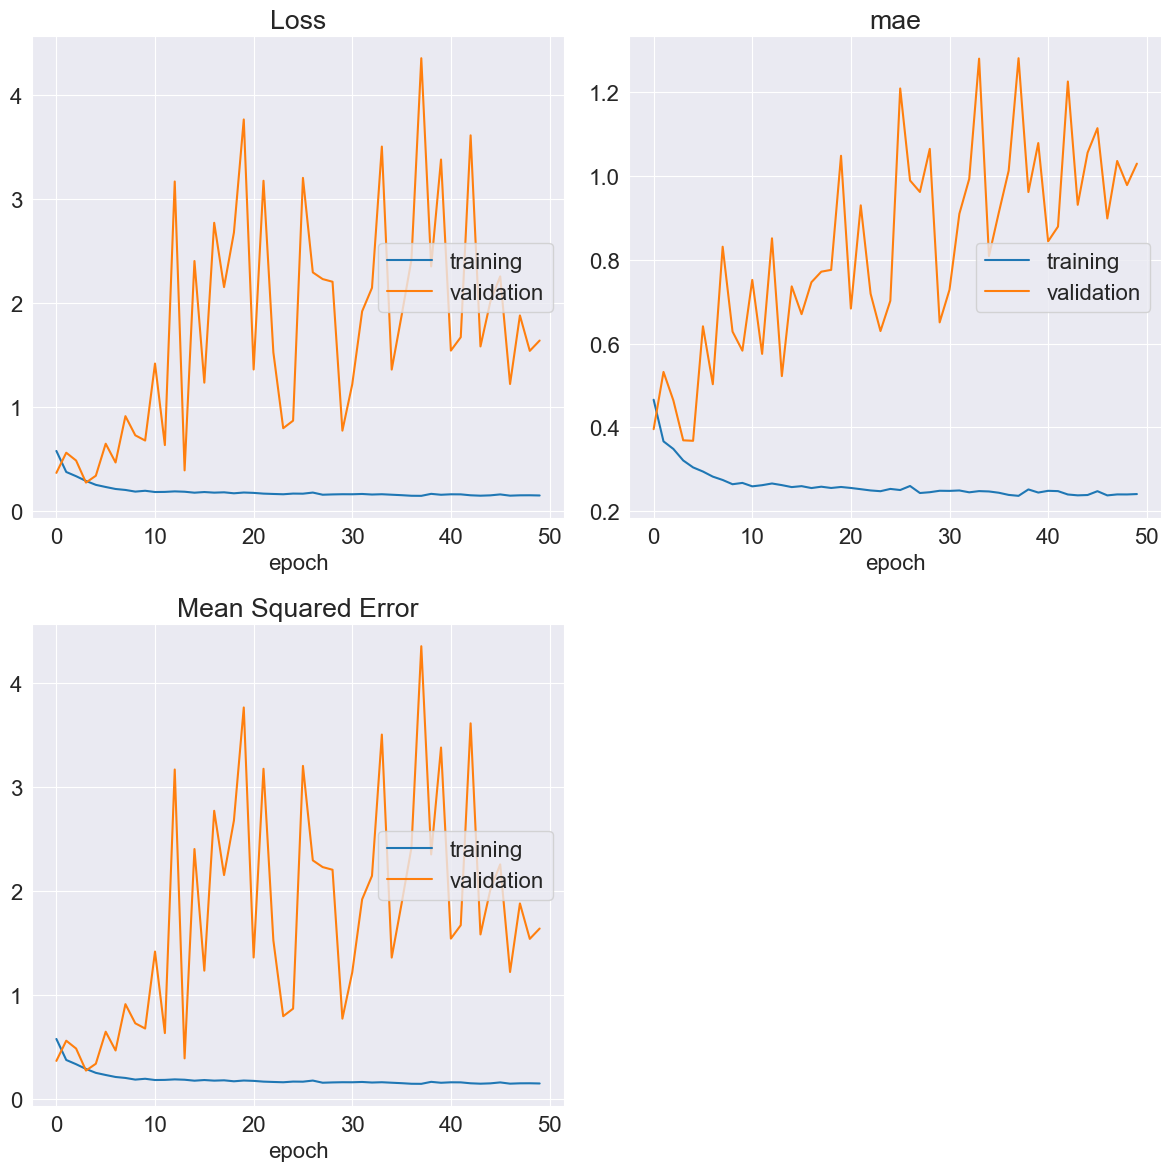

Loss
	training         	 (min:    0.150, max:    0.582, cur:    0.154)
	validation       	 (min:    0.278, max:    4.357, cur:    1.643)
mae
	training         	 (min:    0.237, max:    0.466, cur:    0.241)
	validation       	 (min:    0.368, max:    1.281, cur:    1.029)
Mean Squared Error
	training         	 (min:    0.150, max:    0.582, cur:    0.154)
	validation       	 (min:    0.278, max:    4.357, cur:    1.643)
245/245 [==============================] - 2s 7ms/step - loss: 0.1536 - mae: 0.2410 - mse: 0.1536 - val_loss: 1.6432 - val_mae: 1.0295 - val_mse: 1.6432


In [65]:
fw_multi_timestep_model.fit(training_set, 
                            epochs=EPOCHS, 
                            validation_data=validation_set, 
                            callbacks=[plotlosses])

In [66]:
train_predictions = unnormalize_target(fw_multi_timestep_model.predict(training_set_no_shuffle))[:, 0]
validation_predictions = unnormalize_target(fw_multi_timestep_model.predict(validation_set))[:, 0]

93/93 [==============================] - 0s 4ms/step


,Train MAE,Train MSE,Validation MAE,Validation MSE
Multi step FF NN,7.603432,141.307797,31.596248,1547.816869


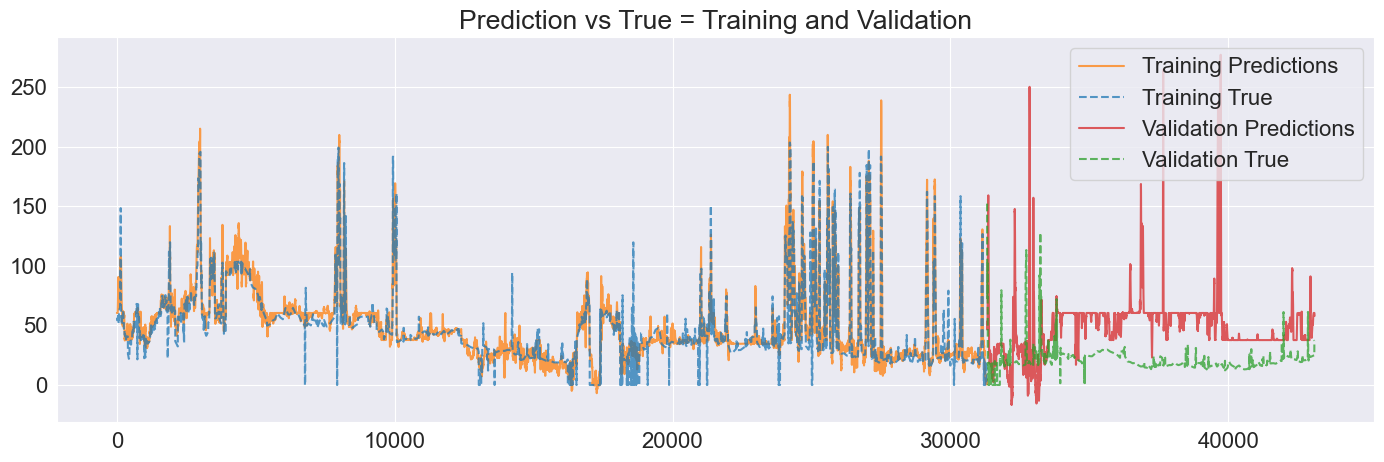

In [67]:
fig, ax, results = show_model_results(train_predictions, validation_predictions, 'Multi step FF NN', y_train_lstm, y_val_lstm)
model_results.append(results)

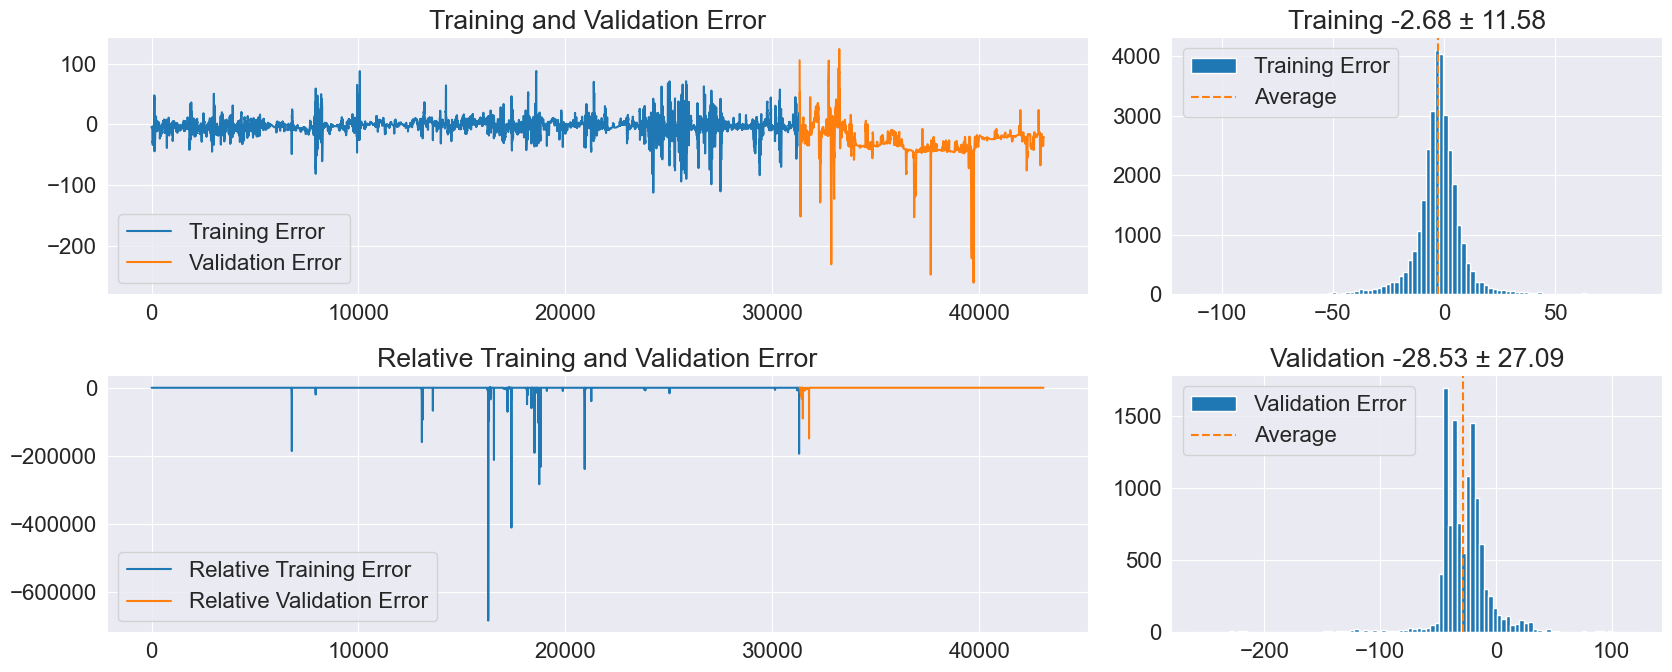

In [68]:
fig, ax = analyze_residuals(train_predictions, validation_predictions, y_train_lstm, y_val_lstm)

### Summary

In [69]:
results = pd.concat(model_results)
results = results.loc[~results.index.duplicated()]
results

,Train MAE,Train MSE,Validation MAE,Validation MSE
Baseline Model,14.652599,990.940456,4.680117,212.830491
Linear Regression Model,15.432197,645.554839,38.469567,1773.935650
Gradient Boosting Model,16.932667,692.604269,30.699960,1047.920492
Feed Forward Neural Network Model,10.750235,334.298621,26.943641,1369.031602
LSTM Neural Network Model,6.682548,114.757679,74.093756,7694.964232
Multi step FF NN,7.603432,141.307797,31.596248,1547.816869


We unfortunately see that the models are not able to predict the future values very well. We did not even come close to the baseline model. The best model is the normal feed forward neural network, but even that one is not very good.

In [70]:
# styled but doesn't work in pycharm
styled_results = results.style.background_gradient(cmap='Blues', axis=None, subset=['Train MAE',])
styled_results = styled_results.background_gradient(cmap='Greens', axis=None, subset=['Train MSE',])
styled_results = styled_results.background_gradient(cmap='Blues', axis=None, subset=['Validation MAE',])
styled_results = styled_results.background_gradient(cmap='Greens', axis=None, subset=['Validation MSE',])
styled_results

,Train MAE,Train MSE,Validation MAE,Validation MSE
Baseline Model,14.652599,990.940456,4.680117,212.830491
Linear Regression Model,15.432197,645.554839,38.469567,1773.935650
Gradient Boosting Model,16.932667,692.604269,30.699960,1047.920492
Feed Forward Neural Network Model,10.750235,334.298621,26.943641,1369.031602
LSTM Neural Network Model,6.682548,114.757679,74.093756,7694.964232
Multi step FF NN,7.603432,141.307797,31.596248,1547.816869
